In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn

# We do not need a dataset so we load the fake input
from meta_learning.backend.pytorch.dataset import NoopData

# We load the optimizers we care about.
from meta_learning.backend.pytorch.optimizer import SGD, Adam 
from meta_learning.backend.pytorch.optimizer import MetaSgd
import meta_learning.backend.pytorch.losses as loss
from meta_learning.backend.pytorch import optimizer as optim

# The model we care about.
from meta_learning.backend.pytorch.model import Rosenbrock

from meta_learning.backend.pytorch.learning import train

In [2]:
# base log dir
logdir = "../pytorch_logs/rosenbrock_example/{}"

# base learning rate
base_lr = 0.001

# memory learning rate
mem_lr = 0.001
clip_grad = 10.0

debug = True

memory_optimizer_fn = optim.memory_optimizer_adam_init(mem_lr)

# training params shared across all experiments
train_params = {'max_iter': 100, 'seed': 1234, 'debug': debug, 'cuda': False}
meta_params = {}
meta_params['num_centers'] = 100
meta_params['use_memory'] = True
meta_params['lm_scale'] = 0.5
meta_params['memory_learning_rate'] = mem_lr
meta_params['min_grad_value'] = -clip_grad
meta_params['max_grad_value'] = clip_grad
meta_params['logspace'] = False 

# starting position for rosenbrock problem
x1_init = 1.5
x2_init = -0.5 

# basic SGD with coordinate-wise gradient clipping
model1 = Rosenbrock(x1_init, x2_init)
sgd_optimizer = SGD(model1.parameters(), lr=base_lr, clip_grad=clip_grad)

# Meta SGD with coordinate-wise gradient clipping 
model2 = Rosenbrock(x1_init, x2_init)
meta_optimizer_1d = MetaSgd(
    model2,
    memory_optimizer_init_fn=memory_optimizer_fn,
    lr=base_lr,
    clip_grad=clip_grad,
    meta_params=meta_params,
    logdir=logdir.format('meta_sgd'),
    debug=debug)

# criterion we want to minimize
criterion = loss.IdentityLoss()
dataset = NoopData(batch_size=1, shard_name='train')

('clip_grad: ', 10.0)
('clip_grad: ', 10.0)


In [3]:
# run 1
train_params['logdir'] = logdir.format('sgd')
result1 = train(model1, sgd_optimizer, criterion, dataset, train_params)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished Training


In [4]:
train_params['logdir'] = logdir.format('meta_sgd_1d')
result2 = train(model2, meta_optimizer_1d, criterion, dataset, train_params)

 59% (59 of 100) |##############          | Elapsed Time: 0:00:00 ETA:  0:00:00

Finished Training


Text(0,0.5,u'MSE')

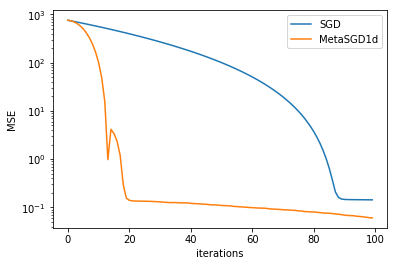

In [5]:
plt.figure()
plt.plot(result1['loss'], label='SGD', color='C0')
plt.plot(result2['loss'], label='MetaSGD1d', color='C1')
plt.yscale('log')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('MSE')